## 사전설정

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip install imbalanced-learn

In [ ]:
!pip install -U sentencepiece datasets transformers pyarrow -q

In [ ]:
!pip install kiwipiepy

In [ ]:
from transformers import BertTokenizer, DonutProcessor
from keras.utils import pad_sequences
from sklearn.model_selection import train_test_split

from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import Counter

import json
from tqdm import tqdm
import glob, shutil, os
from pathlib import Path
from typing import List, Dict, Union, Tuple, Any

import re

from kiwipiepy import Kiwi, Match
kiwi = Kiwi()

In [ ]:
train_annotation_paths = glob.glob('/content/drive/MyDrive/Team_caffeine_holic/01.데이터/1.Training/라벨링데이터/*.zip')

# 임시적으로 생성

def organize_train_dataset(value: str) -> list:
  extract_dir = f'./{value}'
  archive_format = 'zip'

  file_paths = train_annotation_paths

  for filename in file_paths:
    shutil.unpack_archive(filename, extract_dir, archive_format)

  for folder_name, _, file_names in os.walk(extract_dir):
    if len(file_names) > 0:
      for f in file_names:
        current_file = os.path.join(folder_name, f)
        shutil.move(current_file, extract_dir)

  folder_name, sub_folders, _ = next(iter(os.walk(extract_dir)))
  for sf in sub_folders:
    shutil.rmtree(os.path.join(folder_name, sf))

  return glob.glob(os.path.join(extract_dir,'*'))

train_json_files = organize_train_dataset('annotations')

In [ ]:
LATEX_START = "<latex>"
LATEX_END = "</latex>"

new_tokens = [
    LATEX_START,
    LATEX_END
]

In [ ]:
def get_gt_string(files):

  ground_truths = []
  labels = []

  for f in tqdm(files):
    filename = os.path.basename(f)
    filepath = Path(f)

    with open(filepath, encoding='utf-8') as fp:
      data = json.load(fp)

    label = filename.split('_')[2]
    data_series = data['segments']

    all_lines = []

    NON_OBJECT = False

    for d_line in data_series:
      if 'equation' not in d_line:
        NON_OBJECT = True
        break

      if '$' not in d_line['equation']:
        new_line = d_line['equation']
      else:
        equation = d_line['equation'].split('$')
        latex_line = equation[0]
        for i, e in enumerate(equation[1:]):
          if i%2 == 0:
            latex_line += LATEX_START + e
          else:
            latex_line += LATEX_END + e

        new_line = latex_line

      all_lines.append(new_line)

    if not NON_OBJECT:
      ground_truths += all_lines
      labels += [label] * len(all_lines)
    else:
      pass

  return ground_truths, labels

ground_truths, gt_labels = get_gt_string(train_json_files)

100%|██████████| 150450/150450 [00:09<00:00, 15331.55it/s]


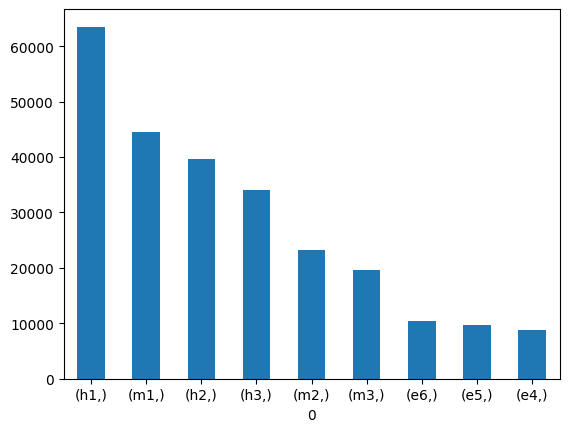

In [ ]:
label_df = pd.DataFrame(gt_labels)
label_df.value_counts().plot(kind='bar')

plt.xticks(rotation=0)

plt.show()

In [ ]:
labels = [
    'e4','e5','e6',
    'm1','m2','m3',
    'h1','h2','h3'
]

id2label = {}
label2id = {}

for i, item in enumerate(labels):
  id2label[i] = item
  label2id[item] = i

# 토크나이저들
- 도넛 프로세서 토크나이저 : 라텍스 부분에서 사용
- 키위파이 토크나이저 : 텍스트 부분에서 사용


> 수학에서 사용되는 사용자 사전 (add_words) 정의,분석에 필요없는 불용어 사전 (stop_words) 정의






In [ ]:
processor = DonutProcessor.from_pretrained("/content/drive/MyDrive/processor")
tokenizer = processor.tokenizer

In [ ]:
from kiwipiepy.utils import Stopwords
stopwords = Stopwords()
add_words=['연립부등식','시속','유리함수','교점','밑변','부분합','쌓기나무','사인법칙','피타고라스','평행이동','대분수','도수분포표','이등변삼각형','상대도수','최솟값','중근','표본공간','닮음비',
          '유한소수','연립부등식','공통범위','각뿔대','극한값','아랫변','수선의발','허근','중근','근과계수의관계','최단거리','교점','홀수항','짝수항','실근','부분집합',
           '진리집합','공비','직사각형','예각삼각형','직각삼각형','일반항','부분집합','부등호','음의정수','항등함수','근의공식','수직이등분선','원주율','입체도형','준식','최댓값',
           '증가량','감소량','일대일대응','대칭이동','음함수','좌변','우변','외심','조임정리','원주각','원순열','초항','점사이의거리','우함수','극댓값','내림차순','중심각','경우의수','기준량',
           '대응각','수직이등분선','사잇값정리','접선의방정식','모눈칸','입체도형','표준형','변화량','벤다이어그램','최고차항','좌표평전','불연속','수직이등분선','도수분포표','이항','다항함수',
           '원주율','연립부등식','정적분','소인수분해','일반항','최고항','상대도수','배반사건','증가함수','접선의기울기','삼수선','공통인수','무리식','일대일함수','닫힌구간','열린구간','기함수',
           '진분수','호의길이','나머지정리','켤레복소수','무게중심','원순열','평균변화율','곱셈공식','이산확률','대응각','대등점','좌표평면','중복조합','차항계수']
stop_words=['정답','개','학생','답','가능','의','라','가','을','은','과','장','철수','무승부','결과','축구','이란','열량','선택','권',
            '동생','여유','테이프','곳','연주','한라산','현주','소금물','금요일','평가','하인','왼쪽','정확','사용','목걸이','여학생','영지',
            '과자','종이','사진','출전','동안','성윤','탈','양궁','무','통장','자전거','개인','고등학교','되어','입장료','바깥','이때','감',
            '시합','인정','도중','에','계절','이므로','옷','야구','를','밖','므','연필','오리','솟값','처음','동전','안','컵','텐트','만약',
            '태준','역사책','어머니','사과','구슬','선생','만족','이용','식량','깃발','오렌지','화요일','반대','인','나','오른쪽','번','아치고',
            '필요','여름','여야','거짓','장마','부분','은행','직','희연','톱니','주머니','서현','청소년','준','고','고르고','못','퀴','최고',
            '풀','모','밀가루','후','메뚜기','월요일','하루','찰흙','정도','지현이','움','우유','기','서','떡','진아','샌드위치','모둠','시',
            '승부','미생물','꽃','올해','단백질','색종이','입','작년','체인','머지','수박','매듭','자취','재경','달리기','팀','인형','초록색',
            '무','이동','줄','제외','여학생','오','버스','추리','마찬가지','발사','세수','선수','조금','습관','회원','껌','영어','수면','하인',
            '눈','사용','영어','임시','양말','바둑돌','각인','회원','잡지','독서량','대회','어린이','진아','르','남학생','여학생','아래','동쪽',
            '어린이','상자','돈','학생','구슬','우유','서','해결','연습','발','맛','와','학교','공차','학기','조각','림','케이스','저금통','시행',
            '하루','반','마을','위쪽','포도','설명','박테리아','부분','사탕','개수','회','도달','병','도','학교','아버지','영희','가지','아들',
            '시작','방법','다음','대신','학업','키','과일','주스','포도','번호','각도기','시행','사탕','생각','후','다','의자','시계',
            '모두','뒤','떡','연습','자리','톱니','어린이','다','학교','명','그릇','라','물','림','제비','학업','설명','다음','대신','몸무게',
            '아래','은','이번','서','연습','배','작년','시작','동화책','생각','앞','제외','하루','학생','여학생','차','가지','방법','포도','와',
            '형','우유','떡','진아','샌드위치','모둠','시','승부']

nums=['일','이','삼','사','오','육','칠','팔','구','십','십일','십이','이십']

for num in nums:
    variant_words=['{}차방정식'.format(num),'정{}각형'.format(num),'{}각기둥'.format(num),'{}각형'.format(num),
                   '{}차함수'.format(num),'{}차곡선'.format(num),'{}각뿔'.format(num),'{}차부등식'.format(num),
                   '{}차식'.format(num)]
    for word in variant_words:
        add_words.append(word)

for word in add_words:
    kiwi.add_user_word(word,'NNG')

for word in stop_words:
    stopwords.add((word, 'NNG'))

masks={'부분 집합':'부분집합','근과 계수와의 관계':'근과계수의관계','꼭짓점의 개수':'꼭짓점개수','다항 함수':'다항함수','접선의 방정식':'접선의방정식',
       '닫힌 구간':'닫힌구간','열린 구간':'열린구간','이등변 삼각형':'이등변삼각형','나무쌓기':'쌓기나무','산술과 기하평균':'산술기하평균','산술 기하평균':'산술기하평균',
       '각 기둥':'각기둥','차항의 계수':'차항계수','경우의 수':'경우의수','최대값':'최댓값','최댓 값':'최댓값','점 사이의 거리':'점사이의거리','사잇값 정리':'사잇값정리','사잇값의 정리':'사잇값정리','소인수 분해':'소인수분해',
       '수선의 발':'수선의발','최단 거리':'최단거리','부분 집합':'부분집합','근의 공식':'근의공식','접선의 방정식':'접선의방정식','호의 길이':'호의길이','나머지 정리':'나머지 정리',
       '접선의 기울기':'접선의기울기'}

for sent in ground_truths:
  for mask in masks.keys():
    if mask in sent:
      re_sent=re.sub(mask,masks[mask],sent)
      sent=re_sent
    else:
      pass

# 텍스트 데이터 정제
- 텍스트 --> 키위 토크나이저로 수학 용어 명사만 추출 <br>
- 라텍스 --> 메인 모델 토크나이저로 수학 기호 (ex)//cos,//left) 형태만 추출  

In [ ]:
tmp_ground_truths=[]

for i,text in enumerate(ground_truths):

    text=text.replace('\\displaystyle','') #displaystyle 제거
    latexs=re.findall('<latex>.*?</latex>',text) # latex 부분만 추출
    texts=re.sub('<latex>.*?</latex>',"",text) # 텍스트 부분만 추출
    text_tokens=kiwi.tokenize(texts,stopwords=stopwords)
    text_nn_tokens=[]
    cleaned_latex_tokens=[]

    for t in text_tokens:
        #텍스트에서 명사만 추출
        if t.tag=='NNG' or t.tag=='NNP':
            text_nn_tokens.append(t.form)

    if len(latexs)>=1: #라텍스가 있는 ground truth일때만 작동
        for latex in latexs:

            latex_tokens=tokenizer.tokenize(latex)
            latex_tokens=[x for x in latex_tokens if x.startswith('\\')] # \\sin,\\cos 등 필요한 기호만 필터링

            if len(latex_tokens)>=1:
                cl_la_tk=' '.join(latex_tokens) #라텍스를 한 문장으로 합침
                cleaned_latex_tokens.append(cl_la_tk)

            else:
                pass
            #cleaned_latex_tokens.append(latex)


    cleaned_text=' '.join(text_nn_tokens)
    cleaned_latex=' '.join(cleaned_latex_tokens)
    cl_gt=cleaned_text+cleaned_latex
    tmp_ground_truths.append(cl_gt)


# sequence 길이 조절
- 12자 이하의 문장들 같은 레이블끼리 묶어 토크나이저 기준 3 단어로 묶어서 길이를 연장

In [ ]:
cleaned_ground_truths=[]
cleaned_labels=[]
tmp_gt_dicts={'e4':[],'e5':[],'e6':[],
              'm1':[],'m2':[],'m3':[],
              'h1':[],'h2':[],'h3':[]}
#tmp_labels=[]
for i,v in enumerate(tmp_ground_truths):
    if 2<=len(v)<=12:
      tmp_gt_dicts[gt_labels[i]].append(v)
    else:
      cleaned_ground_truths.append(v)
      cleaned_labels.append(gt_labels[i])

In [ ]:
uncleaned_ground_truths=[]
uncleaned_labels=[]
tmp_gt_dicts={'e4':[],'e5':[],'e6':[],
              'm1':[],'m2':[],'m3':[],
              'h1':[],'h2':[],'h3':[]}

for i,v in enumerate(tmp_ground_truths):
    if 2<=len(v)<=12:
      tmp_gt_dicts[gt_labels[i]].append(v)
    else:
      uncleaned_ground_truths.append(v)
      uncleaned_labels.append(gt_labels[i])

for k,v in tmp_gt_dicts.items():
  while len(v)>=3:
    if len(v)>=3:
      long_sent=r' '.join(v[:3])
      v=v[3:]
      uncleaned_ground_truths.append(long_sent)
      uncleaned_labels.append(k)

    elif 1<=len(v)<=2:
      long_sent=r' '.join(v)
      v=[]
      uncleaned_ground_truths.append(long_sent)
      uncleaned_labels.append(k)

In [ ]:
cleaned_ground_truths=[]
cleaned_labels=[]
for i,v in enumerate(uncleaned_ground_truths):
  if len(v)>0:
    cleaned_ground_truths.append(v)
    cleaned_labels.append(uncleaned_labels[i])

In [ ]:
for i,v in enumerate(cleaned_ground_truths[:7000]):
  print(len(v),'-',v,'-',cleaned_labels[i])
  print('------------------------------------------')

In [ ]:
Counter(cleaned_labels)

Counter({'h3': 22200,
         'h1': 37634,
         'm1': 28123,
         'h2': 25293,
         'e4': 3909,
         'm2': 16400,
         'm3': 13594,
         'e6': 5506,
         'e5': 5701})

In [ ]:
import statistics

length_max=max([len(x) for x in cleaned_ground_truths])
length_min=min([len(x) for x in cleaned_ground_truths])
length_mean=statistics.mean([len(x) for x in cleaned_ground_truths])
print(length_max)
print(length_min)
print(length_mean)

291
2
12.031948217290736


In [ ]:
X = cleaned_ground_truths[:]
y = cleaned_labels[:]

#tokenized_texts = [" ".join(tokenizer.tokenize(s)) for s in X]
y = [label2id[x] for x in y]

In [ ]:
X[0]

'\\sqrt \\frac \\sqrt \\frac \\sqrt'

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

td_vectorizer = TfidfVectorizer()
# c_vectorizer = CountVectorizer()
X = td_vectorizer.fit_transform(X)
# X = c_vectorizer.fit_transform(tokenized_texts)

In [ ]:
X.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

# 레이블 불균형 해소
- undersampling

In [ ]:
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

undersample = RandomUnderSampler()
X_under, y_under = undersample.fit_resample(X, y)
print(Counter(y_under))

Counter({0: 2392, 1: 2392, 2: 2392, 3: 2392, 4: 2392, 5: 2392, 6: 2392, 7: 2392, 8: 2392})


In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X_under, y_under, random_state=42, test_size=0.1)

In [ ]:
models = []
models.append(('NB-M', MultinomialNB()))
models.append(('NB-B', BernoulliNB()))
models.append(('DT', DecisionTreeClassifier()))
models.append(('RF', RandomForestClassifier()))
models.append(('XGB', XGBClassifier()))

for name, model in models:
    model.fit(X_train, y_train)
    msg = "%s - train_score : %f, test score : %f" % (name, model.score(X_train, y_train), model.score(X_valid, y_valid))
    print(msg)

NB-M - train_score : 0.596748, test score : 0.562471
NB-B - train_score : 0.601084, test score : 0.564329
DT - train_score : 0.780129, test score : 0.475615
RF - train_score : 0.780129, test score : 0.562007
XGB - train_score : 0.684026, test score : 0.572689
